In [1]:
import numpy as np
import MDAnalysis as md 
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_1samp, ttest_ind
import matplotlib.ticker as ticker


In [2]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
plt.rcParams["figure.figsize"] = cm2inch(15,10)
plt.rcParams.update({'font.size':10})
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Enrichment and deplemention 

#### The cutoff for the first lipid shell is set to 7 angstrom
This is based on both visual inspections and RDF curves, where the two first shells lies between ~5 - 14 angstrom

In [3]:
#systems=["FA_G-prot"]
#systems=["FA_G-prot","FA_no_G-prot","IA","PA"]
systems=["IA", "PA", "FA_G-prot", "FA_no_G-prot"]
unique_lipids = ['POPC','POPS','POPE','POPA','POPG','CHOL','DPG3', 'DPSM', 'PAP6']
all_lipids_sele = " ".join(['{0:s}'.format(i) for i in unique_lipids ])
#lipid_dir = {"FA_G-prot":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6"}
lipid_dir = {"FA_G-prot":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6",
            "FA_no_G-prot":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6",
            "IA":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6",
            "PA":"POPC, POPS, POPA, POPG, POPE, CHOL, DPG3, DPSM, PAP6"}


In [4]:
def select_prio(resname,u, priority=["PO4", "GL1", "AM1", "GM1"]):
    """Given a resname a priority selection is made only containing a single bead for the same lipid type"""
    selection=u.select_atoms("resname %s and name PO4 GM1 AM1 ROH GL1" %resname)
    #print (selection)
    if len(selection) != 0:
        if len(selection)!=selection.n_residues:
            beads=np.unique(selection.names)
            #print("%s contains multiple of the listed bead types:" %resname)
            #print("The bead with the highest priority is selected")
            bead_type=priority[np.amin([priority.index(v) for v in beads])]
            #print("Which is %s" %bead_type)
        else:
            beads=np.unique(selection.names)
            bead_type=beads[0]
        new_selection=u.select_atoms("resname %s and name %s" %(resname, bead_type))
        return new_selection
    else:
        return 0


In [4]:
def get_DE_index (s, r, stride):
    """"""
    pdb = "GRO/{0:s}_{1:d}_nowat_mda.pdb".format(s,r) #Has Chain IDs, with R=protein, P=peptide, G=G-protein, S=bilayer
    xtc = "XTC/{0:s}_{1:d}_nowat_res_center_fit_last10ms.xtc".format(s,r)
    lipids = lipid_dir[s]
    lipid_list = lipids.split(',')
    u = md.Universe(pdb,xtc)
    lipid_tot = np.unique(u.select_atoms('resname {0:s}'.format(all_lipids_sele)).resids).shape[0]
    unique_lipids = 'POPC POPS POPA POPG POPE CHOL DPG3 DPSM PAP6'
    #unique_lipid = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM']

    # Select the protein zone
    
    prot = u.select_atoms('name BB SC1 SC2 SC3 SC4')[u.select_atoms('name BB SC1 SC2 SC3 SC4').chainIDs == 'R']
    prot_sele = '(resname {0:s}) and global around 7 group protein'.format(unique_lipids)
    protein_zone = u.select_atoms(prot_sele, protein=prot, updating=True )

    #Select the bulk zone - not overlapping with the protein zone
    bulk_sele = '(resname {0:s}) and not group protein and not group protein_zone'.format(unique_lipids)
    bulk_selection = u.select_atoms(bulk_sele,protein=prot, protein_zone=protein_zone, updating=True)

    P     = np.zeros([len(lipid_list), 3])
    P_tot = np.zeros([len(lipid_list), 3])
    B     = np.zeros([len(lipid_list), 3])

    for ndx, lipid in enumerate(lipid_list):
        print ('lipid:', lipid)
        tot_frames = len(u.trajectory[::stride])

        loc_p     = np.zeros([tot_frames])
        loc_p_tot = np.zeros([tot_frames])
        loc_b     = np.zeros([tot_frames])
        for fdx, ts in enumerate(u.trajectory[::stride]):
            #print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, u.trajectory.time))
            lipid_tot_loc = np.unique(protein_zone.resids).shape[0]
            loc_p_tot[fdx] = lipid_tot_loc
            lipid_circle = select_prio(lipid, protein_zone)
            if type(lipid_circle) != int:
                lipid_circle_num = np.unique(lipid_circle.resids).shape[0]
            else:
                lipid_circle_num = 0
            loc_p[fdx] = lipid_circle_num

            lipid_bulk = select_prio(lipid, bulk_selection)

            if type(lipid_bulk) != int:
                lipid_bulk_num = np.unique(lipid_bulk.resids).shape[0]
            else:
                lipid_bulk_num = 0 
            loc_b[fdx] = lipid_bulk_num
        P[ndx, r]     = np.average(loc_p)
        P_tot[ndx, r] = np.average(loc_p_tot)
        B[ndx, r]     = np.average(loc_b)
        
        

    R_cir  = P[:,r] / P_tot[:,r]
    R_bulk = B[:,r] / lipid_tot
    E = R_cir/R_bulk
    return E

#### Testing

r = 0
s = systems[0]

pdb = "GRO/{0:s}_{1:d}_nowat_mda.pdb".format(s,r)
xtc = "XTC/{0:s}_{1:d}_nowat_res_center.xtc".format(s,r)
lipids = lipid_dir[s]
lipid_list = lipids.split(',')
u = md.Universe(pdb,xtc)
sel = u.select_atoms('name BB SC1 SC2 SC3 SC4')[u.select_atoms('name BB SC1 SC2 SC3 SC4').chainIDs == 'R']

In [127]:
DE_All = []
for s in systems:
    DE = []
    for r in range(3):
        print ('Running system {0:s} repeat {1:d}'.format(s,r))
        DE_loc = get_DE_index(s, r, stride=2)
        np.save('DE_index_{0:s}_{1:d}_last10µs.npy'.format(s,r), np.array(DE_loc))
        DE.append(DE_loc)
        print (np.array(DE_loc).shape)
    np.save('DE_index_{0:s}_last10µs.npy'.format(s), np.array(DE))
    DE_All.append(DE)

Running system IA repeat 0


/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".for

lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
lipid:  PAP6
(9,)
Running system IA repeat 1
lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
lipid:  PAP6
(9,)
Running system IA repeat 2
lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
lipid:  PAP6
(9,)
Running system PA repeat 0
lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
lipid:  PAP6
(9,)
Running system PA repeat 1
lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
lipid:  PAP6
(9,)
Running system PA repeat 2
lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
lipid:  PAP6
(9,)
Running system FA_G-prot repeat 0
lipid: POPC
lipid:  POPS
lipid:  POPA
lipid:  POPG
lipid:  POPE
lipid:  CHOL
lipid:  DPG3
lipid:  DPSM
li

In [5]:
#np.save('DE_index_all_last10µs.npy', np.array(DE_All))
DE = np.load('DE_index_all_last10µs.npy')

In [6]:
#DE = np.array(DE_All)

In [7]:
DE.shape

(4, 3, 9)

In [8]:
import statsmodels.api as sm 
import pylab as py
from scipy.stats import shapiro

In [9]:
shapiro(DE[0,:,:])

ShapiroResult(statistic=0.5604251623153687, pvalue=7.337058605116908e-08)

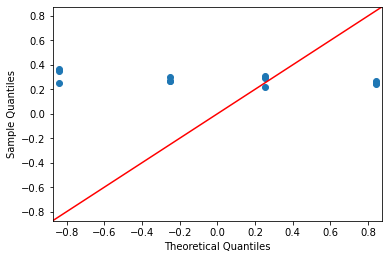

In [10]:
sm.qqplot(DE[:,:,0], line ='45') 
py.show()

In [11]:
systems
#systems = ['IA','PA', 'FA_G-prot','FA_no_G-prot']

['IA', 'PA', 'FA_G-prot', 'FA_no_G-prot']

In [12]:
DE_ava = np.average(DE, axis=1)
DE_std = np.std(DE, axis=1)

In [13]:
DE_ava.shape

(4, 9)

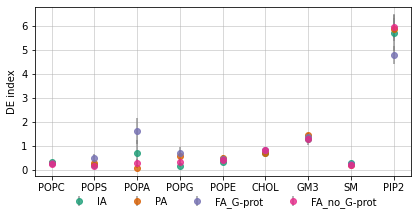

In [14]:
plt.rcParams["figure.figsize"] = cm2inch(15,8)
plt.rcParams.update({'font.size':10})


lipid_list = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
#color_list = ['#e66101','#fdb863','#b2abd2','#5e3c99']
#color_list = ['#7570b3','#e7298a','#1b9e77','#d95f02']
color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
for i in range(4):
    plt.errorbar([0,1,2,3,4,5,6,7,8], DE_ava[i], yerr=DE_std[i], ecolor='grey', fmt='o', label=systems[i], color=color_list[i], alpha=0.8)


plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.6)
plt.ylabel('DE index')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), frameon=False, ncol=4)
plt.tight_layout()
#plt.savefig('DE_index_all_last10ms_ver2.png', dpi=300, bbox_inches='tight')

In [15]:
DE_ava.shape

(4, 9)

In [16]:
DE_ava[:2].shape

(2, 9)

In [17]:
systems[-2:]

['FA_G-prot', 'FA_no_G-prot']

In [18]:
system_labels = ['Inactive', 'Partial active','Fully active w Gs', 'Fully active wo Gs']

In [20]:
p_values =  np.array([ ttest_1samp(DE[i,:,j], popmean=1).pvalue for i in range(4) for j in range(9) ]).reshape([4,9])

In [ ]:
plt.rcParams.update({'font.size':10})

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=cm2inch(16,10))

lipid_list = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
color_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
colors_lipids = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

for i in range(2):
    bar = ax[0,i].bar([0,1,2,3,4,5,6,7,8], DE_ava[:2][i], yerr=DE_std[:2][i], ecolor='grey',
                color=colors_lipids)
    ax[0,i].set_title(system_labels[:2][i])
    ax[0,i].hlines(1, 0,8, linestyle='dotted', color='black', alpha=0.6)
    ax[0,i].set_xticks([0,1,2,3,4,5,6,7,8])
    ax[0,i].set_xticklabels(lipid_list_translated, rotation='60')
    ax[0,i].set_ylabel('DE index')
    for l in range(9):
        if p_values[2:][i][l] <= 0.05:
            ax[0,i].text(l, 5, "*", fontsize=9)
    
    
for j in range(2):
    bar = ax[1,j].bar([0,1,2,3,4,5,6,7,8], DE_ava[-2:][j], yerr=DE_std[-2:][j], ecolor='grey', 
                color=colors_lipids, tick_label=p_values[:-2][j])
    ax[1,j].set_title(system_labels[-2:][j])
    ax[1,j].set_yticks([1,2,3,4,5,6])
    ax[1,j].hlines(1, 0,8, linestyle='dotted', color='black', alpha=0.6)
    ax[1,j].set_xticks([0,1,2,3,4,5,6,7,8])
    ax[1,j].set_xticklabels(lipid_list_translated, rotation='60')
    ax[1,j].set_ylabel('DE index')   
    for l in range(9):
        if p_values[:-2][j][l] <= 0.05:
            ax[1,j].text(l, 5, "*", fontsize=9)
    
plt.subplots_adjust(hspace=0.8)
plt.savefig('DE_index_bars_new.png', dpi=300, bbox_inches='tight')

In [139]:
p_values.shape

(4, 9)

In [140]:
p_values[:-2].shape

(2, 9)

In [152]:
p_values[:,-1]

array([0.01250074, 0.00501445, 0.00452322, 0.0046093 ])

In [153]:
systems

['IA', 'PA', 'FA_G-prot', 'FA_no_G-prot']

In [23]:
np.savetxt('DE_index_p_values_last10ms.txt', p_values)

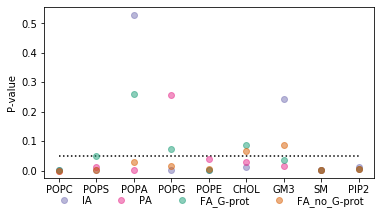

In [141]:
#color_list = ['#e66101','#fdb863','#b2abd2','#5e3c99']
color_list = ['#7570b3','#e7298a','#1b9e77','#d95f02']
for i in range(4):
    plt.plot(p_values[i], 'o', label=systems[i], alpha=0.5, color=color_list[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=4)
plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.hlines(0.05, 0, 8, linestyle='dotted')
plt.ylabel('P-value')
plt.savefig('p_values_DE_index_last10ms.png', dpi=300, bbox_inches='tight')

##This is significance compare to bulk. Not between the conformations. 

In [31]:
ttest_ind(DE[0,:,0], DE[1,:,0]).pvalue

0.5501643226658957

In [142]:
np.array([ ttest_ind(DE[i,:,0], DE[i+1, :, 0]).pvalue for i in range(3)])

array([0.31683047, 0.8256031 , 0.55016432])

In [143]:
p_values_sys = np.zeros([9,4,4])
for j in range(9):
    for i in range(4):
        for ii in range(4):
            p_values_sys[j,i,ii] = ttest_ind(DE[i,:,j], DE[ii,:,j]).pvalue
            #p_values_sys.append(ttest_ind(DE[i,:,j], DE[ii,:,j]).pvalue)
            

In [144]:
systems

['IA', 'PA', 'FA_G-prot', 'FA_no_G-prot']

In [145]:
for i in range(4):
    for ii in range(4):
        print (systems[i], systems[ii])
        print(ttest_ind(DE[i,:,2], DE[ii,:,2]).pvalue)

IA IA
1.0
IA PA
0.19374858084115848
IA FA_G-prot
0.1788489414694853
IA FA_no_G-prot
0.35335445545318755
PA IA
0.19374858084115848
PA PA
1.0
PA FA_G-prot
0.017591710122613374
PA FA_no_G-prot
0.24129054184362525
FA_G-prot IA
0.1788489414694853
FA_G-prot PA
0.017591710122613374
FA_G-prot FA_G-prot
1.0
FA_G-prot FA_no_G-prot
0.031068930233968735
FA_no_G-prot IA
0.35335445545318755
FA_no_G-prot PA
0.24129054184362525
FA_no_G-prot FA_G-prot
0.031068930233968735
FA_no_G-prot FA_no_G-prot
1.0


In [146]:
p_values_systems = np.array(p_values_sys).reshape([9,4,4])

In [39]:
systems

['FA_G-prot', 'FA_no_G-prot', 'IA', 'PA']

In [147]:
p_values_systems.shape

(9, 4, 4)

In [14]:
#np.save('P_values_10µs_acorss_systems.npy', p_values_systems)
p_values_systems = np.load('P_values_10µs_acorss_systems.npy')

## Saving p-values to an excel ark 

In [106]:
import pandas as pd

In [148]:
writer = pd.ExcelWriter('p-values_across_systems.xlsx', engine='xlsxwriter')

for i in range(9):
    df = pd.DataFrame(data=p_values_systems[i], columns=systems, index=systems)
    df.to_excel(writer, sheet_name=lipid_list_translated[i])
writer.save()


([<matplotlib.axis.YTick at 0x7f4a8584cc50>,
 <a list of 4 Text yticklabel objects>)

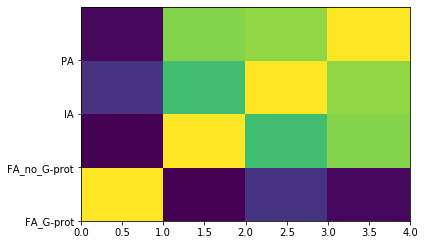

In [62]:
plt.pcolormesh(p_values_systems[-1])
plt.yticks([0,1,2,3], systems)

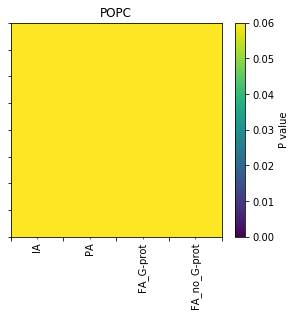

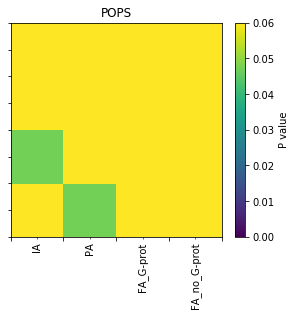

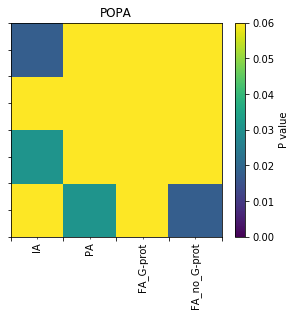

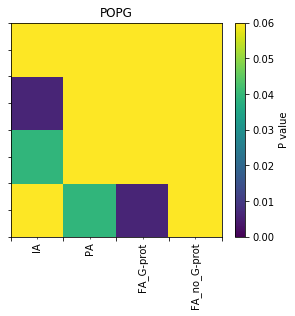

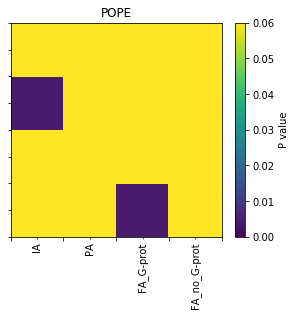

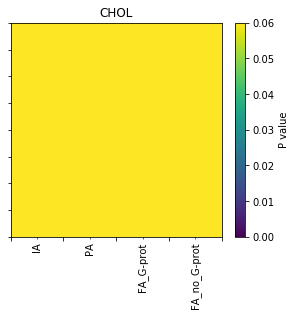

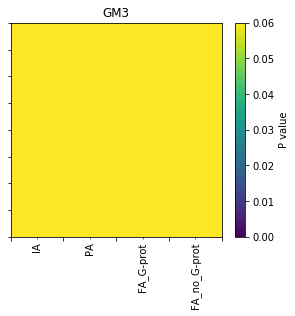

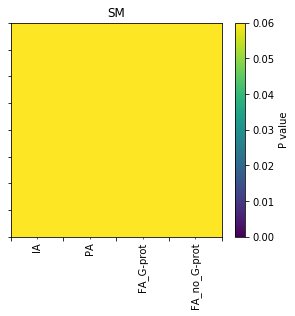

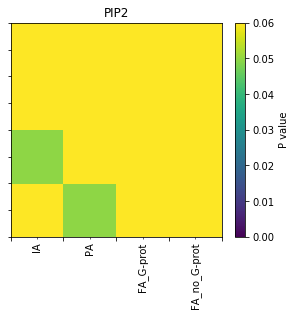

In [119]:
#lipids = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
lipids = lipid_list_translated
for i in range(9):
    
    fig,ax = plt.subplots(figsize=cm2inch(12,10))
    im = ax.pcolor(p_values_systems[i], vmin=0, vmax=0.06)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.set_yticklabels(["{:1.2f}".format(i) for i in cb.get_ticks()])
    cb.set_label('P value')
    # Hide major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(systems))
    ax.yaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(systems))
    
    for tick in ax.xaxis.get_minor_ticks():
        tick.label1.set_horizontalalignment('center')
    for tick in ax.yaxis.get_minor_ticks():
        tick.label1.set_horizontalalignment('center')
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    ax.set_title(lipids[i])
    #plt.savefig('DE_index_P_values_{0:s}_last10ms.png'.format(lipids[i]), dpi=300, bbox_inches='tight')
    plt.show()
    

In [45]:
pwd

'/home/au447022/Documents/GCGR_Complex_LB/LIVER/ALL'

################################################################

DE_G_prots = np.array(DE)[6:,:]
DE_IA_PA = np.array(DE)[:6,:]

DE_G_prot = DE_G_prots[3:,:]
DE_no_G_prot = DE_G_prots[:-3,:]
DE_IA  = DE_IA_PA[3:,:]
DE_PA = DE_IA_PA[:-3,:]

In [12]:
#DEs = [DE_G_prot, DE_no_G_prot, DE_IA, DE_PA]

In [19]:
color_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
alpha_value = [0.4, 0.6, 0.8]
label_list = ["FA_G-prot","FA_no_G-prot","IA","PA"]

for s in range(4):
    plt.plot([0,1,2,3,4,5,6,7,8], DEs[s,r,:]),'o', color=color_list[s], alpha=alpha_value[r], label=label_list[s])

plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.ylabel('log(DE) index')
plt.tight_layout()
#plt.savefig('log(DE)_all_rep.png', dpi=300, bbox_inches='tight')

IndexError: index 0 is out of bounds for axis 1 with size 0

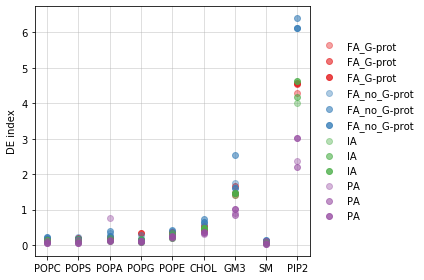

In [27]:
color_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
alpha_value = [0.4, 0.6, 0.8]
label_list = ["FA_G-prot","FA_no_G-prot","IA","PA"]

for s in range(4):
    for r in range(3):
        plt.plot([0,1,2,3,4,5,6,7,8], np.array(DEs)[s,r,:],'o', color=color_list[s], alpha=alpha_value[r], label=label_list[s])

plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.ylabel('DE index')
plt.tight_layout()
plt.savefig('DE_all_rep.png', dpi=300, bbox_inches='tight')

In [33]:
def get_ava_std (DE):
    DE_a = np.average(np.array(DE), axis=0)
    DE_std = np.std(np.array(DE), axis=0)
    return DE_a, DE_std

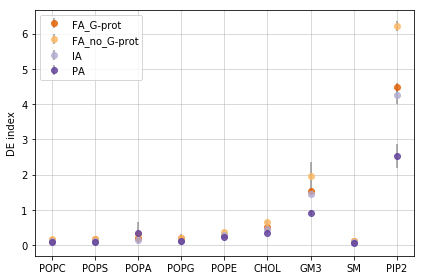

In [53]:
lipid_list = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
color_list = ['#e66101','#fdb863','#b2abd2','#5e3c99']

for idx, DE in enumerate(DEs):
    ava, std = get_ava_std(DE)
    plt.errorbar([0,1,2,3,4,5,6,7,8], ava, yerr=std, ecolor='grey', fmt='o', label=systems[idx], color=color_list[idx], alpha=0.8)


plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.6)
plt.ylabel('DE index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('DE_index_all.png', dpi=300, bbox_inches='tight')

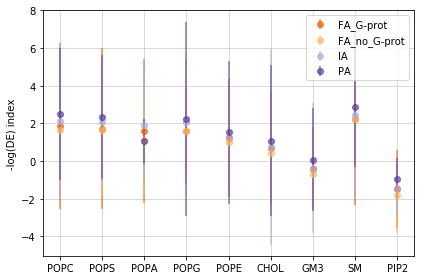

In [50]:
lipid_list = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
color_list = ['#e66101','#fdb863','#b2abd2','#5e3c99']

for idx, DE in enumerate(DEs):
    ava, std = get_ava_std(DE)
    plt.errorbar([0,1,2,3,4,5,6,7,8], -1*np.log(ava), yerr=np.log(std), ecolor=color_list[idx], fmt='o', label=systems[idx], color=color_list[idx], alpha=0.7)


plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.6)
plt.ylabel('-log(DE) index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('log_DE_index_all.png', dpi=300, bbox_inches='tight')

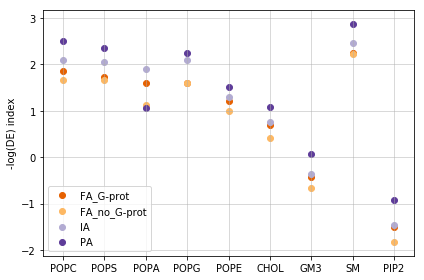

In [45]:
lipid_list = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
color_list = ['#e66101','#fdb863','#b2abd2','#5e3c99']

for idx, DE in enumerate(DEs):
    ava, std = get_ava_std(DE)
    plt.scatter([0,1,2,3,4,5,6,7,8], -1*np.log(ava), marker='o', label=systems[idx], color=color_list[idx])


plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.6)
plt.ylabel('-log(DE) index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('log_DE_index_all_no_std.png', dpi=300, bbox_inches='tight')

In [9]:
DE = np.load('DE_index_all_new_only_GCGR_whole_sim.npy')
dirr = "/home/au447022/Documents/GCGR_Complex_LB/LIVER/FA/GCGR_GCG/"
DE_no_G = np.load(dirr+'DE_index_all_new_only_GCGR_whole_sim.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/au447022/Documents/GCGR_Complex_LB/LIVER/FA/GCGR_GCG/DE_index_all_new_only_GCGR_whole_sim.npy'

In [58]:
DE_a = np.average(np.array(DE), axis=0)
DE_std = np.std(np.array(DE), axis=0)

DE_no_G_a = np.average(np.array(DE_no_G), axis=0)
DE_no_G_std = np.std(np.array(DE_no_G), axis=0)

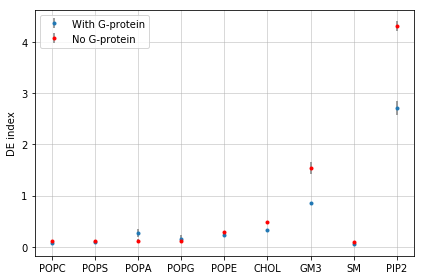

In [60]:
lipid_list = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'DPG3', 'DPSM', 'PAP6']
lipid_list_translated = ['POPC', 'POPS', 'POPA', 'POPG', 'POPE', 'CHOL', 'GM3', 'SM', 'PIP2']
plt.errorbar([0,1,2,3,4,5,6,7,8], DE_a, yerr=DE_std, ecolor='grey', fmt='.', label='With G-protein')
plt.errorbar([0,1,2,3,4,5,6,7,8], DE_no_G_a, yerr=DE_no_G_std, ecolor='grey', fmt='.', color='red', label='No G-protein')
plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.6)
plt.ylabel('DE index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('DE_index_W_Wo_G-prot.png', dpi=300)

In [50]:
DE_a[np.where(DE_a < 1 )]  = 1 / DE_a[np.where(DE_a < 1 )] 

In [51]:
DE_no_G_a[np.where(DE_no_G_a < 1 )]  = 1 / DE_no_G_a[np.where(DE_no_G_a < 1 )] 

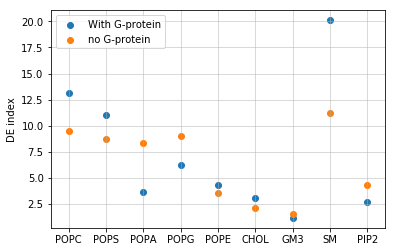

In [56]:
plt.scatter([0,1,2,3,4,5,6,7,8], DE_a, label='With G-protein')
plt.scatter([0,1,2,3,4,5,6,7,8], DE_no_G_a,  label='no G-protein')
plt.xticks([0,1,2,3,4,5,6,7,8], lipid_list_translated)
plt.grid(alpha=0.6)
plt.ylabel('DE index')
plt.legend(loc='best')

In [37]:
d = [0.009  , 0.613 , -0.233 ,  0.551   ,0.487  , 0.318 ,  0.265  , 0.545   ,0.565,   0.465,0.281]

In [38]:
np.average(d)

0.35145454545454546